### File descriptions
    sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.

    test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.
    
    sample_submission.csv - a sample submission file in the correct format.
    
    items.csv - supplemental information about the items/products.

    item_categories.csv  - supplemental information about the items categories.

    shops.csv- supplemental information about the shops.

### Data fields
    
    > ID - an Id that represents a (Shop, Item) tuple within the test set
    
    > shop_id - unique identifier of a shop
    
    > item_id - unique identifier of a product
    
    > item_category_id - unique identifier of item category
    
    > item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
    
    > item_price - current price of an item
    
    > date - date in format dd/mm/yyyy
    
    > date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
    
    > item_name - name of item
    
    > shop_name - name of shop
    
    > item_category_name - name of item category

# EDA

Exploratory Data Analysis (EDA) is an approach to analyze the data using visual techniques. It is used to discover trends, patterns, or to check assumptions with the help of statistical summary and graphical representations



.

## 1. Loading Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pdb 

import time
from itertools import product
from math import ceil
import gc

import warnings

from tqdm import tqdm

In [2]:
sales_train = pd.read_csv('sales_train.csv')
test = pd.read_csv('test.csv')
sample_sub = pd.read_csv('sample_submission.csv')
items = pd.read_csv('items.csv')
item_cat = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')


## 2. Data Preparation

In [3]:
# remove rows contain -1  
sales_train = sales_train[sales_train['item_cnt_day'] != -1]

Text(0.5, 1.0, 'item_price')

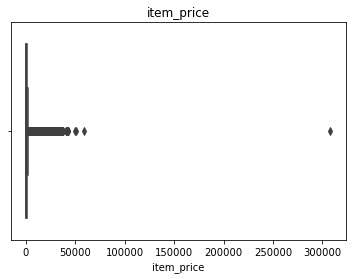

In [4]:
# item with more than 51k price are outlier
warnings.filterwarnings('ignore')

sns.boxplot(sales_train['item_price']).set_title("item_price")

item with more than 51k price are outlier 

<AxesSubplot:xlabel='item_cnt_day'>

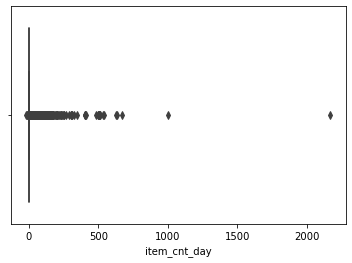

In [5]:
sns.boxplot(sales_train['item_cnt_day'])

items having more than 1000 'iten_cnt_day' are outlier 

In [6]:
# removing outlier 

sales_train = sales_train[sales_train['item_price'] <= 50000]
sales_train = sales_train[sales_train['item_cnt_day'] < 1000]


In [7]:
#removing value less than 0         

sales_train[sales_train.item_cnt_day <= 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
59155,10.01.2013,0,12,1590,2599.000000,-5.0
59156,18.01.2013,0,12,1590,2599.000000,-6.0
59161,18.01.2013,0,12,1593,1799.000000,-3.0
59162,26.01.2013,0,12,1593,1799.000000,-2.0
79029,03.01.2013,0,59,14931,699.000000,-2.0
...,...,...,...,...,...,...
2664172,21.05.2015,28,42,6426,2499.000000,-2.0
2678824,05.06.2015,29,41,6503,999.333333,-3.0
2698705,08.06.2015,29,12,14831,1259.000000,-2.0
2820908,28.08.2015,31,28,5613,5481.000000,-2.0


In [8]:
# removing item_cnt_day less than 1

sales_train = sales_train[sales_train.item_cnt_day > 0]

**grouping data in monthly format**


AS we need to predict sell of any item on next month so data need to be in month format
where we have item's sales each month which would help to predict next month data


In [9]:
#ques - create df with id, item, item_count_per_month 
df = sales_train.groupby(['shop_id','date_block_num', 'item_id']).agg({ 'item_cnt_day':np.sum}).reset_index()
df.columns = ['shop_id','date_block_num','item_id','item_cnt_month']


<AxesSubplot:xlabel='item_cnt_month'>

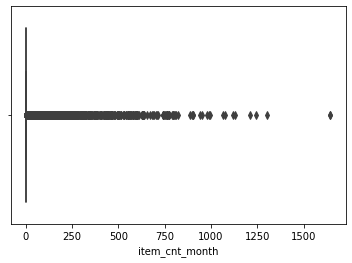

In [10]:
sns.boxplot(df['item_cnt_month'])

In [11]:

# outlier remove
df = df[df.item_cnt_month <1000]

In [35]:
df[df.date_block_num == 33].shop_id.unique()

array([ 2,  3,  4,  5,  6,  7,  9, 10, 12, 14, 15, 16, 18, 19, 20, 21, 22,
       24, 25, 26, 28, 31, 34, 35, 36, 37, 38, 39, 41, 42, 44, 45, 46, 47,
       48, 49, 50, 52, 53, 55, 56, 57, 58, 59], dtype=int64)

In [12]:
df.head()

,shop_id,date_block_num,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


<AxesSubplot:xlabel='shop_id'>

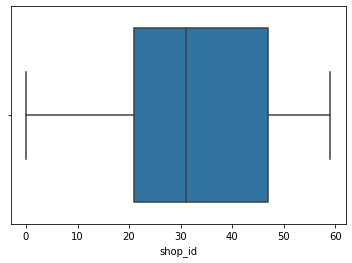

In [13]:
sns.boxplot(df['shop_id'])

## 3. Data Exploration

Our EDA objective will be to understand how the variables in this dataset relate to the sale price of the house.
<pre>

so basically we start with univariate analysis
then we do bivariate and multivarite where we look how features have relation with 'item_cnt_month'
</pre>

<!-- To finding some pattern and inshight we will focus on item, item_cat first -->


<pre>
lets start with target variable 'item_cnt_month', see how it looks like :-
</pre>

In [14]:

df.item_cnt_month.describe()

count    1.608214e+06
mean     2.264094e+00
std      7.865674e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.970000e+02
Name: item_cnt_month, dtype: float64

Text(0.5, 1.0, 'item count per month')

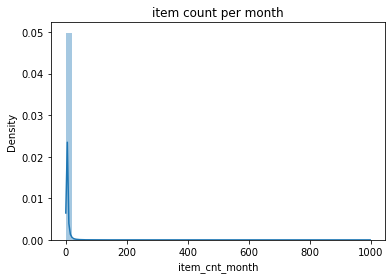

In [15]:


sns.distplot(df.item_cnt_month)
plt.title("item count per month")

<AxesSubplot:xlabel='item_cnt_month', ylabel='Density'>

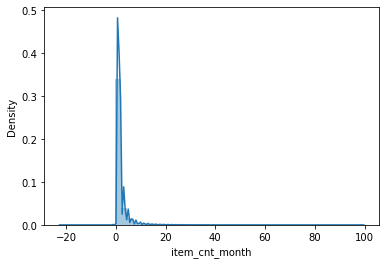

In [276]:
sns.distplot(df[df.item_cnt_month<100].item_cnt_month)

as we can see: 

 - **it's have long positive skewness**
 - **showing peakedness**
 



In [42]:
#skewness and kurtosis
print("Skewness: %f" % df['item_cnt_month'].skew())
print("Kurtosis: %f" % df['item_cnt_month'].kurt())

Skewness: 51.033314
Kurtosis: 4057.684035


ohh that's a large skewness which could be because of seanality, holidays or any other reason  

let's explore other features also and find out which feature could be useful
now we will do bivariate analysis 

**Relationship with categorical features**

<p>
we have " shop_id, date_block_num, item_id " and etc as categorical feature</p>

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1608214 entries, 0 to 1608222
Data columns (total 4 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   shop_id         1608214 non-null  int64  
 1   date_block_num  1608214 non-null  int64  
 2   item_id         1608214 non-null  int64  
 3   item_cnt_month  1608214 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 61.3 MB


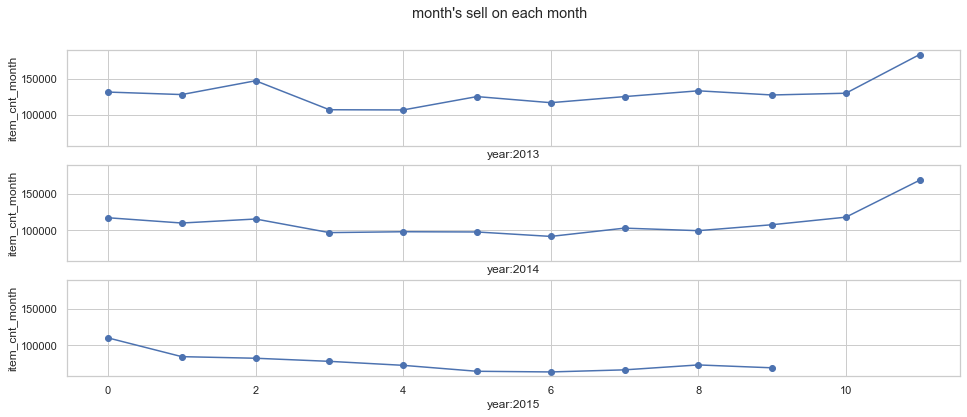

In [29]:
# ques - how much total sell in each month


temp_df = gr.groupby(['date_block_num']).agg({'item_cnt_month':np.sum})

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(16,6))
fig.suptitle("month's sell on each month")
sns.set(style = 'whitegrid')

for i in range(1,4):
    # saperating year
    month_range = 12*i
    temp = 0
    if i ==3:
        month_range = 34
        temp = 2
        
    axes[i-1].plot(list(range(12-temp)), temp_df.values[36-(12*(4-i)) :month_range])         
    axes[i-1].scatter(list(range(12-temp)), temp_df.values[36-(12*(4-i)) :month_range]) 
    axes[i-1].set_ylabel('item_cnt_month')
    axes[i-1].set_xlabel('year:{}'.format(2012+i))
    
#         axes[i][j].axis([0,12,min(gr.values)-10000,max(gr.values)+10000])

plt.axes
plt.show()


<pre>clearly, there is peak at the end of each year probabily dua to holiday season.
so <b>adding year and month feature</b> is helpful to capture this pattern.

as we have items so checking the itemwise selling pattern would be helpful but 
due to having large number of item its better to check item_cat
which is very few comparetivily.
</pre>

<!-- <pre>so not </pre> -->

**how shops behaving and different with each other in term of their avg sales**
<pre>
as we have seen the monthly tread now in order to move forward 
let's check how each shop's avg sales rate different to each other 
</pre>


Wall time: 1min 9s


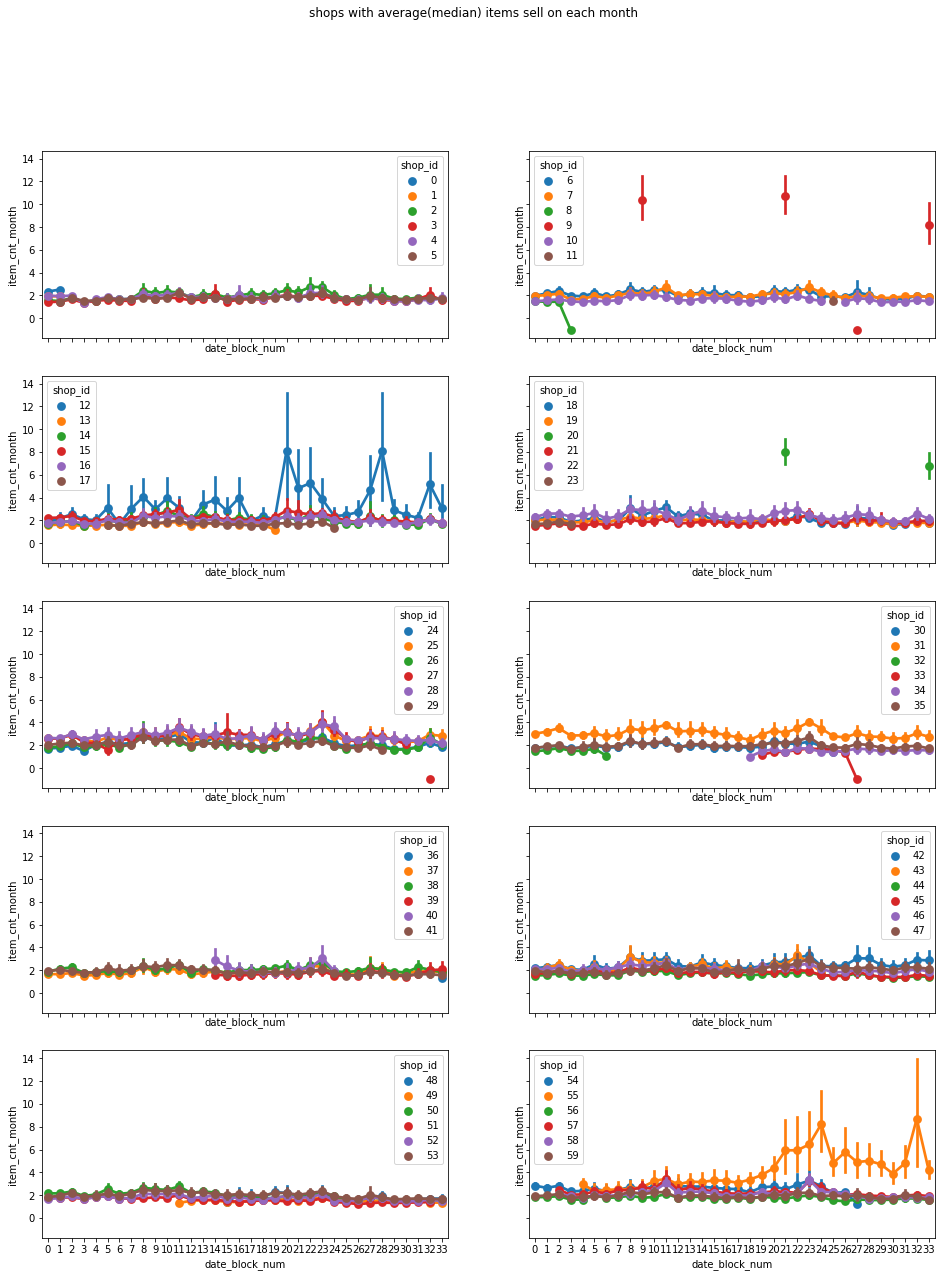

In [278]:
%%time
# answer

from math import ceil 
# grouped = pd.DataFrame(sales_train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(16,20))
fig.suptitle('shops with average(median) items sell on each month')

num_graph = 10
id_per_graph = ceil(df.shop_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_month', hue='shop_id', data=df[np.logical_and(count*id_per_graph <= df['shop_id'], df['shop_id'] < (count+1)*id_per_graph)], ax=axes[i][j])
        count += 1

below plot is same as above but in more readable format

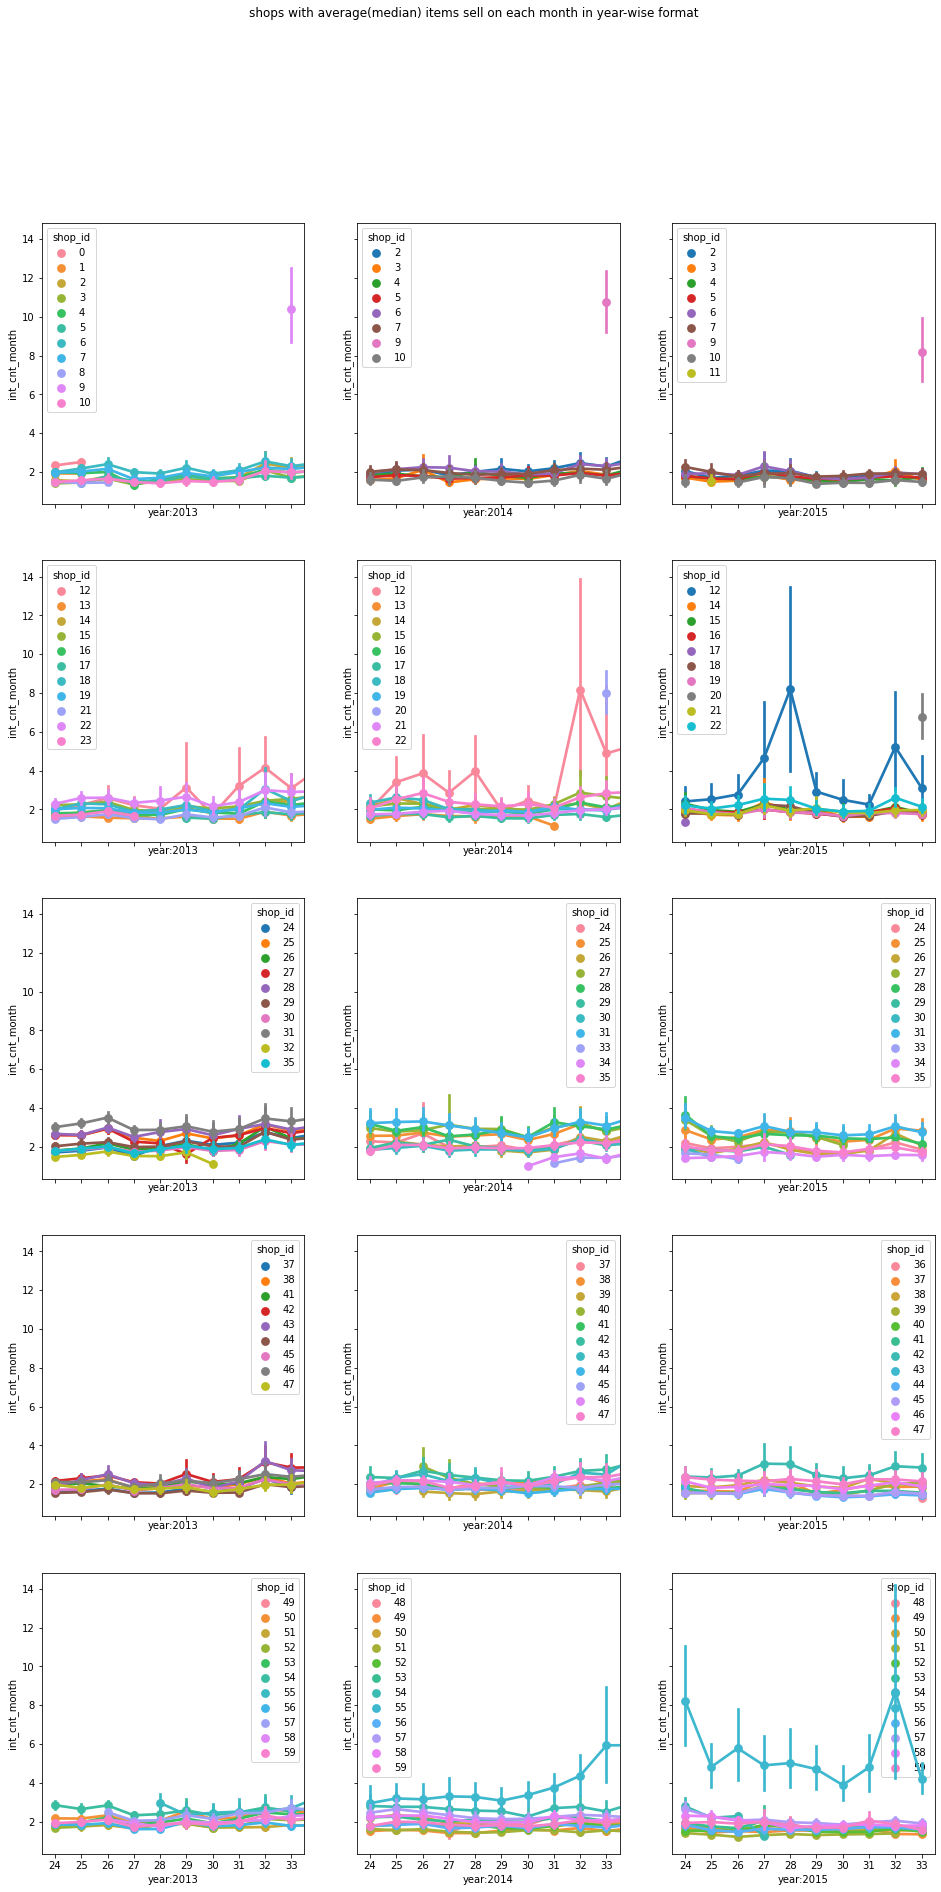

Wall time: 2min 19s


In [249]:
%%time
# ques - check each shop in each month and see if any insight


fig, axes = plt.subplots(nrows=5, ncols=3, sharex=True, sharey=True, figsize=(16,30))
fig.suptitle('shops with average(median) items sell on each month in year-wise format')

count= 0
id_per_graph= ceil(df['shop_id'].max()/5)

for i in range(1,6):
    # saperating year
        
#     axes[i-1].plot(list(range(12-temp)), gr.values[36-(12*(4-i)) :month_range])         
#     axes[i-1].scatter(list(range(12-temp)), gr.values[36-(12*(4-i)) :month_range]) 
#     sns.relplot()
    temp_df = df[np.logical_and(count*id_per_graph <= df['shop_id'], df['shop_id'] < (count+1)*id_per_graph)]
    
    for j in range(1,4):
        month_range = 12*j

        
        sns.pointplot(x='date_block_num', y='item_cnt_month', hue='shop_id', 
                          data= temp_df[(temp_df['date_block_num']>= 36-(12*(4-j))) & (temp_df['date_block_num']< month_range) ], ax=axes[i-1][j-1])
        
        axes[i-1][j-1].set_xlabel('year:{}'.format(2012+j))
        axes[i-1][j-1].set_ylabel('int_cnt_month')
    count += 1
    

# plt.axes
plt.show()


<pre>
yup that's how picture looks like :
most of shop distribution are overlapping while some shops have high sales rate
one things we can notice (if we ignore peaks)- future sell is more like depend/predictable by seeing past recent sell 
</pre>

**let's move to item_category_id feature and mine the hidden insight** 

merging items info to df 

In [17]:
df = df.merge(items, how= 'left', on = 'item_id')
# droping name as we don't use it
df = df.drop(['item_name'], axis=1)
df.head()

,shop_id,date_block_num,item_id,item_cnt_month,item_category_id
0,0,0,32,6.0,40
1,0,0,33,3.0,37
2,0,0,35,1.0,40
3,0,0,43,1.0,40
4,0,0,51,2.0,57


<h3 style="color:red">Pending</h3>

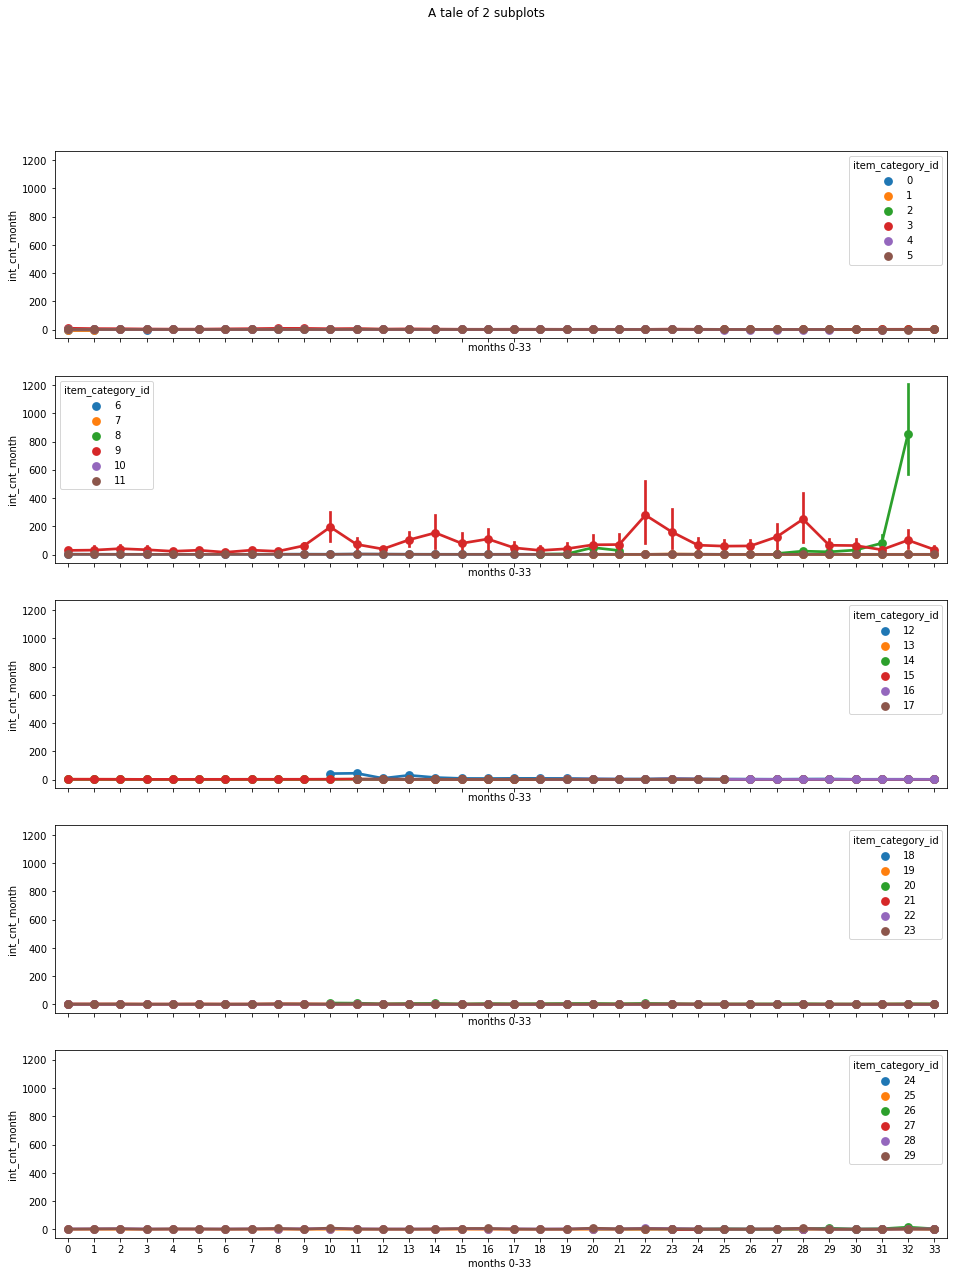

Wall time: 55.8 s


In [62]:
%%time
# ques - check avg sales in eaxh categories in each month and see if any insight


fig, axes = plt.subplots(nrows=5, ncols=1, sharex=True, sharey=True, figsize=(16,20))
fig.suptitle('shops with average(median) items sell on each month')

count= 0
id_per_graph= ceil(df['item_category_id'].max()/15)

for i in range(1,6):
    # saperating year
    month_range = 12*i
    temp = 0
    if i ==3:
        month_range = 34
        temp = 2
        
#     axes[i-1].plot(list(range(12-temp)), gr.values[36-(12*(4-i)) :month_range])         
#     axes[i-1].scatter(list(range(12-temp)), gr.values[36-(12*(4-i)) :month_range]) 
#     sns.relplot()
    sns.pointplot(x='date_block_num', y='item_cnt_month', hue='item_category_id', 
                      data=df[np.logical_and(count*id_per_graph <= 
                                                  df['item_category_id'], df['item_category_id'] < (count+1)*id_per_graph)], ax=axes[i-1])

    axes[i-1].set_ylabel('int_cnt_month')
    axes[i-1].set_xlabel('months 0-33 ')
    count += 1

# plt.axes
plt.show()


<pre>
most of category monthly median selling items are between 1-5.
one more thing to notice item category 9 avg item_cnt_month is close to 200 in month november(both year) 
which could be because of any festival.
this could be use when we have to predict november month data corresponding to this item_cat
</pre>
 

**wrt to single category - median/avg item_cnt_month** 

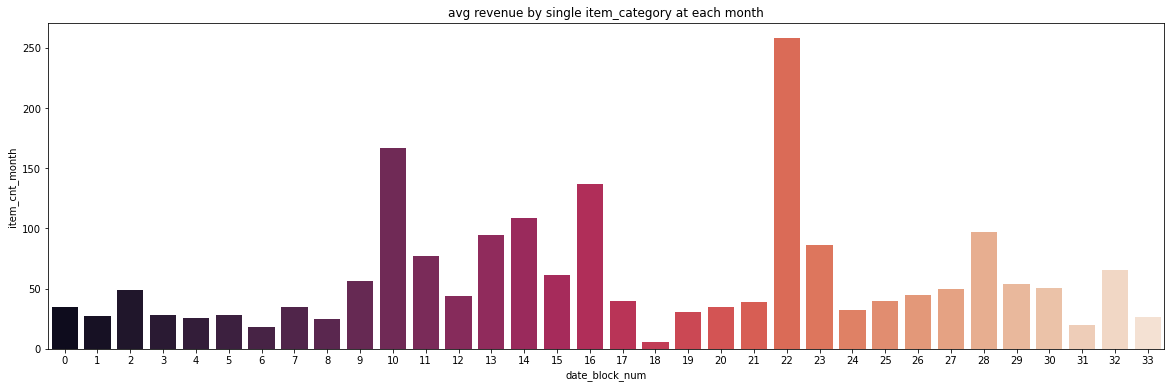

In [31]:
category_id  = 9

fig, ax = plt.subplots(figsize=(20,6))
temp_df = df[df.item_category_id == category_id].groupby(['date_block_num','item_category_id']).agg({'item_cnt_month':np.median}).reset_index()
sns.barplot(x="date_block_num", y="item_cnt_month", data=temp_df, ax=ax, palette="rocket").set_title("avg revenue by single item_category at each month")
plt.show()

In [239]:
# # corresponding to category shop how many unique number of items avail in overall data

# fig, ax = plt.subplots(figsize=(16,6))
# sns.histplot(x ='item_category_id' ,data = items,ax=ax, palette="rocket").set_title("item associated with item_category_id")
# plt.show()

<!-- <h3 style="color:red">Pending</h3>
 -->
some more basic qna to understand category feature 
 
**which category sell more**

**avg revenue by each item_category over all month**

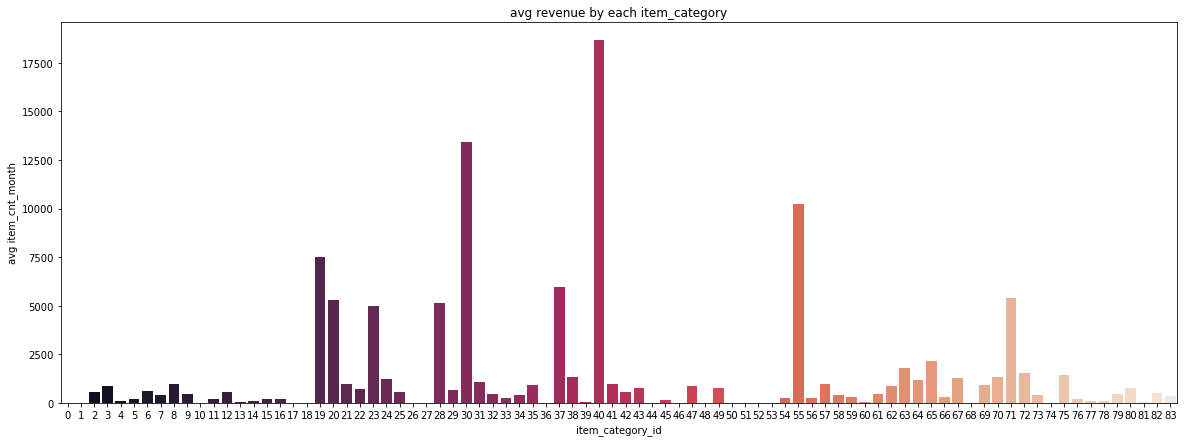

In [285]:
fig, ax = plt.subplots(figsize=(20,7))
temp_df = df.groupby(['item_category_id','date_block_num']).agg({'item_cnt_month':np.sum}).reset_index()
temp_df2 = temp_df.groupby('item_category_id').agg({'item_cnt_month':np.mean}).reset_index()
sns.barplot(x="item_category_id", y="item_cnt_month", data=temp_df2, ax=ax, palette="rocket").set_title("avg revenue by each item_category")
plt.ylabel('avg item_cnt_month')
plt.show()

**total revenue by each item_category**

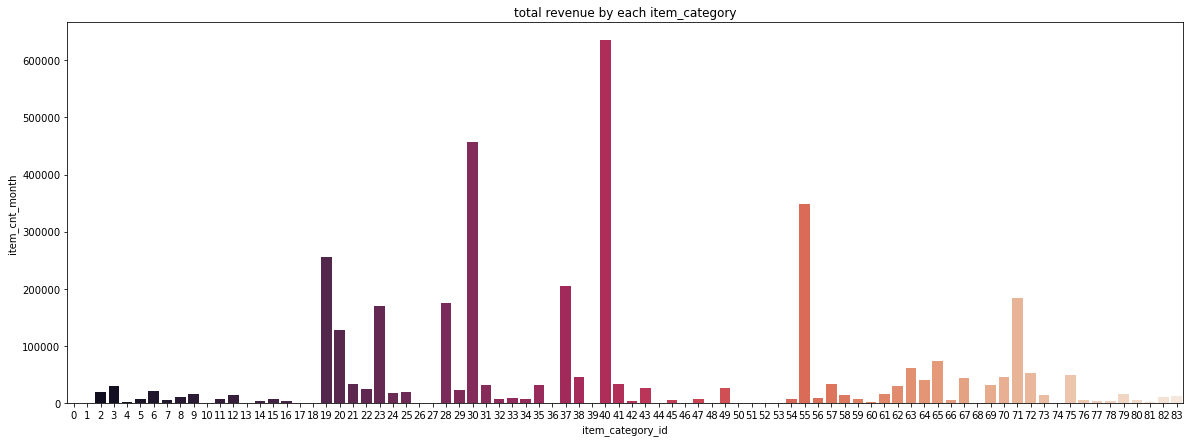

In [219]:
fig, ax = plt.subplots(figsize=(20,7))
temp_df = df.groupby('item_category_id').agg(np.sum).reset_index()
sns.barplot(x="item_category_id", y="item_cnt_month", data=temp_df, ax=ax, palette="rocket").set_title("total revenue by each item_category")
plt.show()

**corresponding to category how many unique number of items avail**

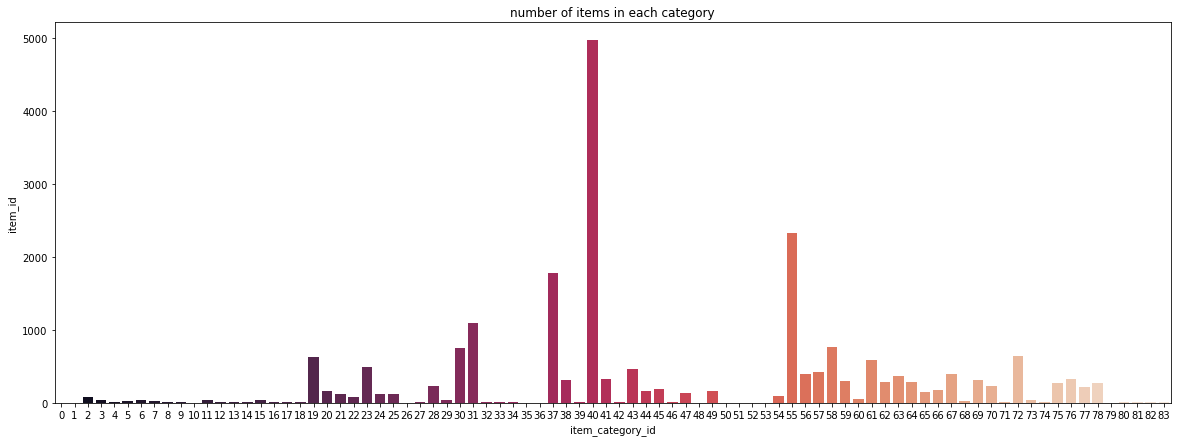

In [238]:
d = df.groupby(["item_category_id","item_id"]).agg({'item_id':np.size})
d.columns = ['cnt_item']
d = d.reset_index()
temp_df = d.groupby(['item_category_id']).agg({'item_id':np.size}).reset_index()


fig, ax = plt.subplots(figsize=(20,7))
# temp_df = df.groupby('shop_id').agg(np.sum).reset_index()
sns.barplot(x="item_category_id", y="item_id", data=temp_df, ax=ax, palette="rocket").set_title("number of items in each category")
plt.show()

### relation between price and sell
<pre>
so basically we choose some random items and will try to
to find some insight about the relation between price and sell 
</pre>

[4954, 8514, 22085, 20831, 3326, 10729, 18774, 5550, 884, 13484, 13328, 2457, 3383, 4098, 10457, 15545, 19027, 14725, 13499, 6837]


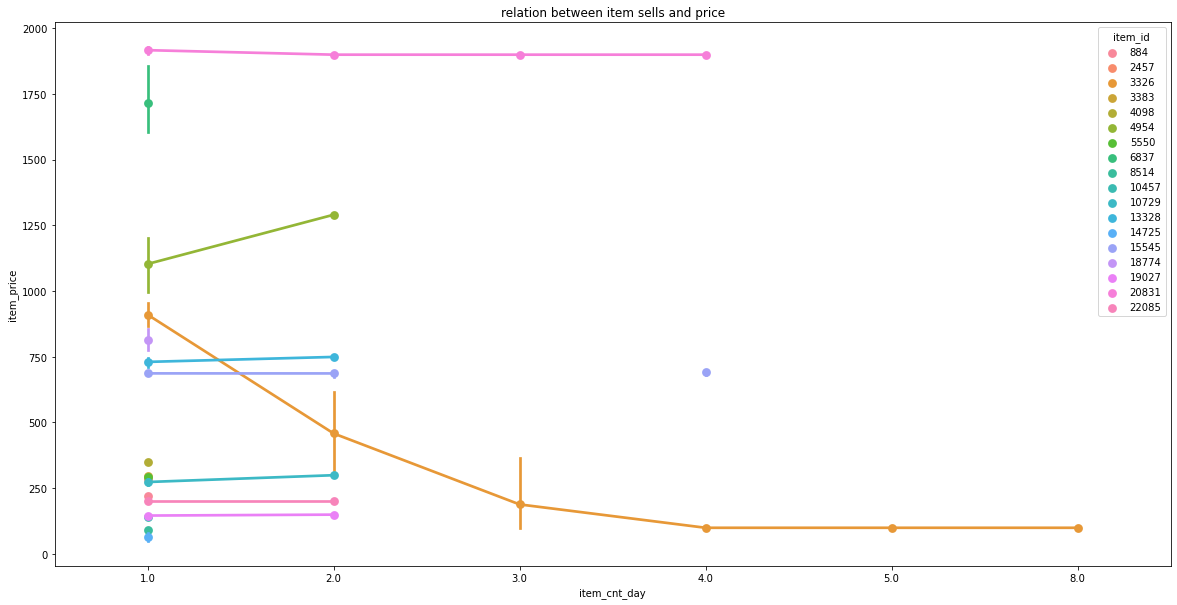

In [34]:
import random
random.seed(20)

# select 20 random items 
rand_ids = random.sample(list(items['item_id']), 20)
print(rand_ids)

temp_df = sales_train[(sales_train['item_id'].isin(rand_ids)) & (sales_train['item_price']<5000) ]
temp_df.shape

plt.figure(figsize=(20,10))

sns.pointplot(x ='item_cnt_day', y='item_price',hue ='item_id', data = temp_df).set_title("relation between item sells and price")
plt.show()

<pre>

some of items's sell is effect by changing item's price
to capture this info, we can include price feature.
but doesn't seem much important as price does change most oftenly for most of the items.
like item_id= 2457 price decresed and item_cnt_day increased
</pre>

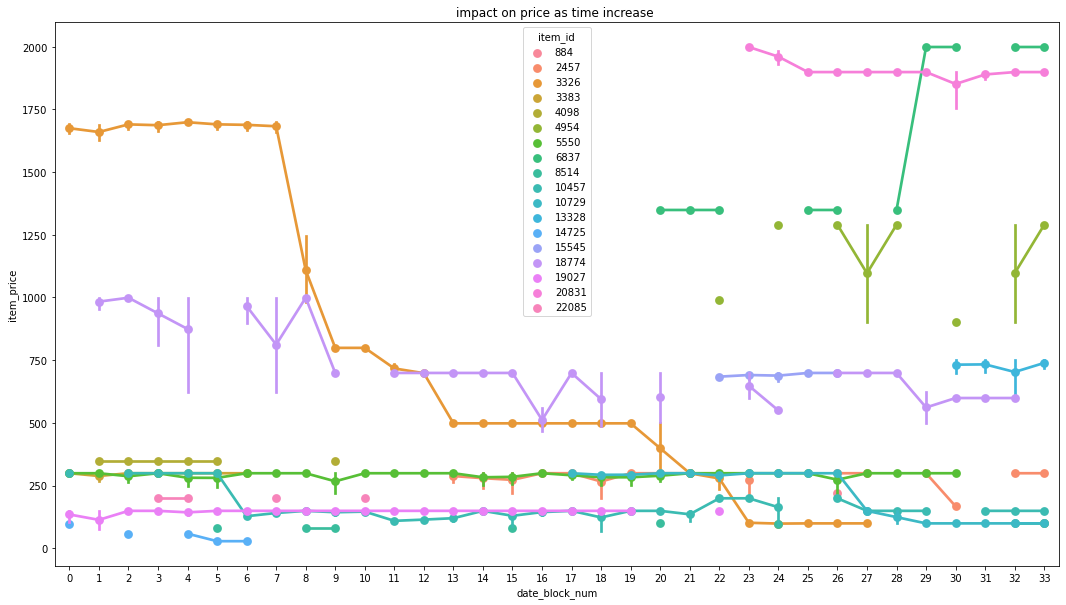

In [77]:
# impact on price as time(/date_block_num) increase  
plt.figure(figsize=(18,10))

sns.pointplot(x ='date_block_num', y='item_price',hue ='item_id', data = temp_df).set_title("impact on price as time increase ")
plt.show()

**wrt one item**

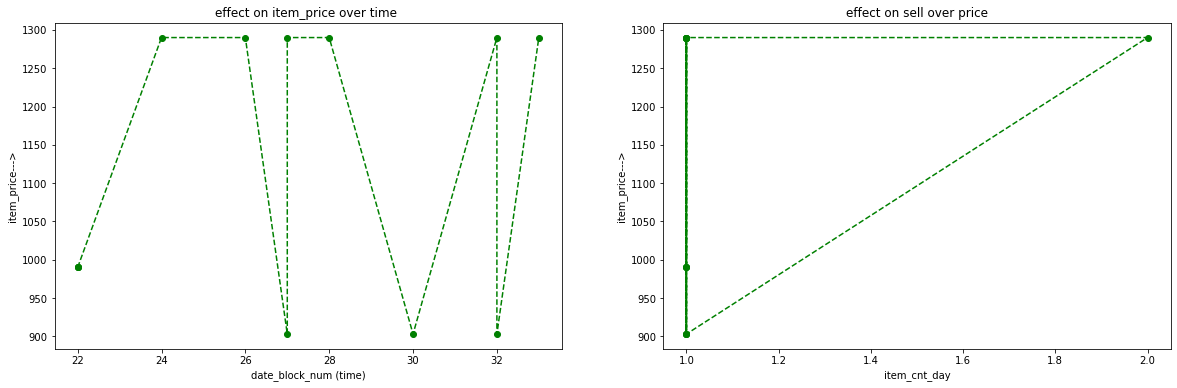

In [263]:
# wrt one item 
temp_df = sales_train[(sales_train['item_id'].isin(rand_ids))]
temp_df2 = temp_df[temp_df.item_id ==4954 ]

fig, axes= plt.subplots(nrows=1, ncols=2,figsize= (20,6))

axes[0].plot(temp_df2.date_block_num, temp_df2.item_price, 'go--')
axes[0].set_xlabel('date_block_num (time)')
axes[0].set_ylabel('item_price--->')
axes[0].title.set_text('effect on item_price over time ')

axes[1].plot(temp_df2.item_cnt_day, temp_df2.item_price, 'go--')
axes[1].set_xlabel('item_cnt_day')
axes[1].set_ylabel('item_price--->')
axes[1].title.set_text('effect on sell over price')


plt.show()

**it seems**
<pre>
price feature relation with itm_cnt_day doesn't seem much related or linear 
to our target variable,
like here price is iecreasing and decreasing over time but it doesn't impact on item_cnt_day
hence we should discard using the price feature.  
</pre>

**let's change the format of analysis litle bit**

so now we will do analysis in "question - answer" format which seems interesting  

**ques - how much data available for indivisual shops in overall 34 months or in how many months a single shop appear ?**

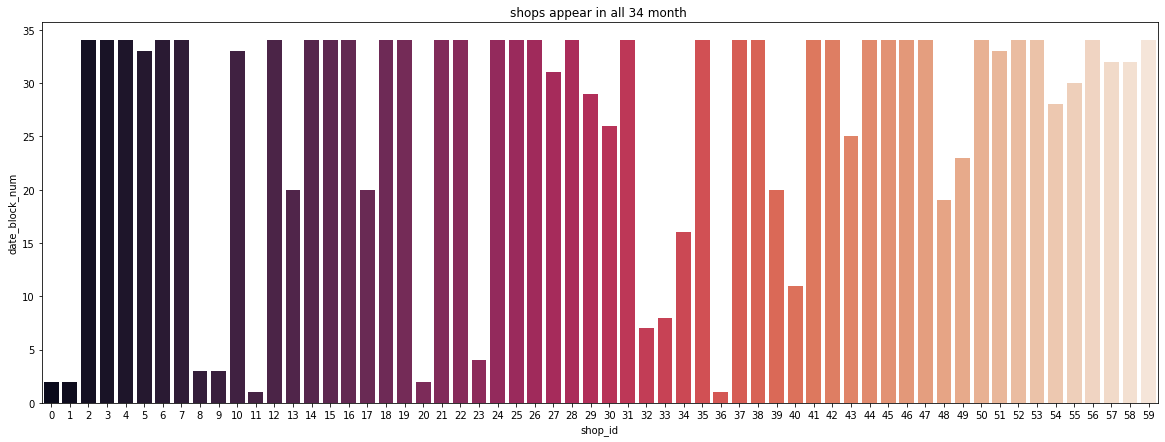

In [190]:
d = df.groupby(["shop_id","date_block_num"]).agg({'shop_id':np.size})
d.columns = ['cnt_shop']
d = d.reset_index()
temp_df = d.groupby(['shop_id']).agg({'date_block_num':np.size}).reset_index()


fig, ax = plt.subplots(figsize=(20,7))
# temp_df = df.groupby('shop_id').agg(np.sum).reset_index()
sns.barplot(x="shop_id", y="date_block_num", data=temp_df, ax=ax, palette="rocket").set_title("shops appear in all 34 month ")
plt.show()

most of shop_id is appearing in all 34 month while some shop is appearing for short time period 

**wrt single shop - we have 2 months data in year 2013 where shop  - 'Якутск Орджоникидзе, 56 фран' id = 0 appears** 

In [169]:
#observation -  wrt single shop we have 12 months in year 2013 where shop  - 'Якутск Орджоникидзе, 56 фран' id = 0 appears 


temp_df1 = df[df.shop_id == 0]
print(' month -\n',temp_df1['date_block_num'].unique())

# print('\n years - ', temp_df1['year'].unique())

# plt.hist(temp_df2)

 month -
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]


**wrt single item - we have only 5 months or in year 2014  where item  - 'ABBYY FineReader 12 Professional Edition ' id = 1 appears** 

In [113]:


temp_df2 = df[df['item_id'] == 1]
print('month -',temp_df2['date_block_num'].unique())

# print('\n years - ', temp_df2['year'].unique())


month - [15 18 19 20 21]


**data wrt sigle shop and single item**

In [173]:
# data wrt sigle shop and single item 

df[(df['shop_id'] == 2) & (df['item_id'] == 27)]

,shop_id,date_block_num,item_id,item_cnt_month,item_category_id
8103,2,0,27,1.0,19
15798,2,17,27,1.0,19


**corresponding to every shop how many unique number of items avail in overall data**

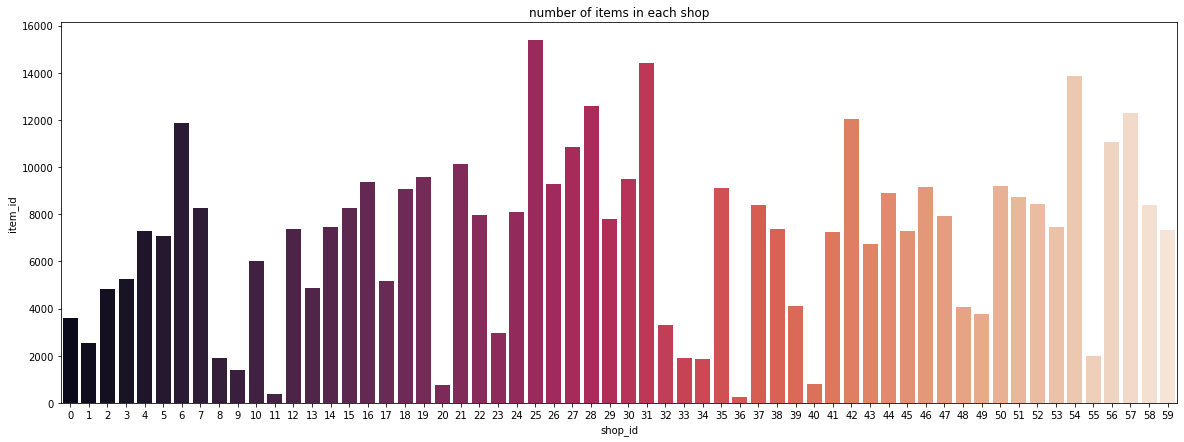

In [189]:
d = df.groupby(["shop_id","item_id"]).agg({'shop_id':np.size})
d.columns = ['cnt_item']
d = d.reset_index()
temp_df = d.groupby(['shop_id']).agg({'item_id':np.size}).reset_index()


fig, ax = plt.subplots(figsize=(20,7))
# temp_df = df.groupby('shop_id').agg(np.sum).reset_index()
sns.barplot(x="shop_id", y="item_id", data=temp_df, ax=ax, palette="rocket").set_title("number of items in each shop")
plt.show()

## 4. Embedding

next........

...
<!-- 
**rolling window**

in rolling window operation we perform statistic operation on the moving window where
window represent range and statistic operation are mean, median, mode , min, max etc
pandas provide rolling() which provide rolling window calculations gives values at each time stamp.

refer- https://medium.com/data-science-at-microsoft/introduction-to-feature-engineering-for-time-series-forecasting-620aa55fcab0 -->